In [19]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely import Polygon
from rasterio.crs import CRS
import xdem
import scipy as sci
import scipy.ndimage as snd
import geoutils as gu
import rasterio as rio
import rioxarray as riox
import cartopy
import cartopy.crs as ccrs


from jiflr import ROOT
from jiflr.data import read_rgi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
rgig = read_rgi("G")
rgic = read_rgi("C")

print(rgig.columns)
print(rgic.columns)
rgig

Index(['rgi_id', 'o1region', 'o2region', 'glims_id', 'anlys_id', 'subm_id',
       'src_date', 'cenlon', 'cenlat', 'utm_zone', 'area_km2', 'primeclass',
       'conn_lvl', 'surge_type', 'term_type', 'glac_name', 'is_rgi6',
       'termlon', 'termlat', 'zmin_m', 'zmax_m', 'zmed_m', 'zmean_m',
       'slope_deg', 'aspect_deg', 'aspect_sec', 'dem_source', 'lmax_m',
       'geometry'],
      dtype='object')
Index(['rgi_id', 'o1region', 'o2region', 'cenlon', 'cenlat', 'utm_zone',
       'area_km2', 'geometry'],
      dtype='object')


,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry
0,RGI2000-v7.0-G-01-00001,01,01-01,G204091E67414N,392889,624,2008-09-02T00:00:00,-155.909404,67.413726,5,...,1485.31760,1693.62350,1544.66940,1553.94030,17.606613,342.330469,1,COPDEM30,725,"POLYGON Z ((-155.90493 67.41630 0.00000, -155...."
1,RGI2000-v7.0-G-01-00002,01,01-01,G204121E67419N,392890,624,2008-09-02T00:00:00,-155.879114,67.419232,5,...,1278.40060,1394.76570,1328.55660,1330.91500,19.846369,345.367012,1,COPDEM30,484,"POLYGON Z ((-155.87867 67.41748 0.00000, -155...."
2,RGI2000-v7.0-G-01-00003,01,01-01,G204471E67431N,392897,624,2008-09-02T00:00:00,-155.530786,67.431484,5,...,1294.70340,1704.74200,1423.20680,1437.23520,23.690063,13.467490,1,COPDEM30,1099,"POLYGON Z ((-155.53113 67.43564 0.00000, -155...."
3,RGI2000-v7.0-G-01-00004,01,01-01,G204497E67431N,392899,624,2008-09-02T00:00:00,-155.501948,67.430514,5,...,1224.17880,1286.89770,1249.63060,1249.06620,12.782562,42.854332,2,COPDEM30,652,"POLYGON Z ((-155.49973 67.43211 0.00000, -155...."
4,RGI2000-v7.0-G-01-00005,01,01-01,G204521E67429N,392901,624,2008-09-02T00:00:00,-155.478173,67.432873,5,...,1052.44010,1488.12990,1290.89230,1273.78340,17.148510,299.058193,8,COPDEM30,1903,"POLYGON Z ((-155.49636 67.43891 0.00000, -155...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27504,RGI2000-v7.0-G-01-27505,01,01-06,G232055E58382N,419220,624,2005-08-15T00:00:00,-127.943494,58.381563,9,...,1856.43870,2095.01120,1958.53970,1956.88500,30.104969,24.649687,2,COPDEM30,757,"POLYGON Z ((-127.94181 58.38319 0.00000, -127...."
27505,RGI2000-v7.0-G-01-27506,01,01-06,G232006E58375N,419219,624,2005-08-15T00:00:00,-127.994907,58.374932,9,...,1871.68970,2229.32130,2045.29190,2041.02940,28.225796,85.414560,3,COPDEM30,915,"POLYGON Z ((-127.99182 58.37815 0.00000, -127...."
27506,RGI2000-v7.0-G-01-27507,01,01-06,G231997E58381N,419218,624,2005-08-15T00:00:00,-128.003487,58.380406,9,...,1762.79870,2032.12080,1913.04610,1907.25850,26.389137,348.349361,1,COPDEM30,714,"POLYGON Z ((-128.00042 58.38169 0.00000, -127...."
27507,RGI2000-v7.0-G-01-27508,01,01-06,G231855E58382N,419215,624,2005-08-15T00:00:00,-128.146532,58.381816,9,...,1982.91860,2225.51100,2126.63960,2120.08740,25.529028,70.835080,3,COPDEM30,489,"POLYGON Z ((-128.14445 58.37975 0.00000, -128...."


<Axes: >

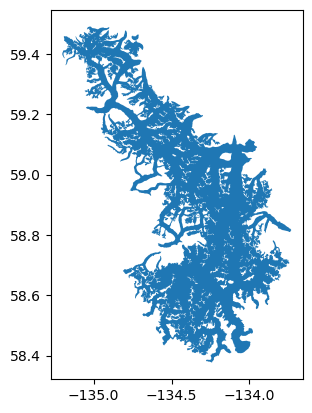

In [21]:

jif = rgic.sort_values(by="area_km2", ascending=False).iloc[[5]]
wolv = rgig.loc[rgig.glac_name == "Wolverine Glacier"]
lemon = rgig.loc[rgig.glac_name == "Lemon Creek Glacier"]
taku = rgig.loc[rgig.glac_name == "Taku Glacier"]

jif.geometry.plot()

In [22]:


# get all the individual glaciers within the complex
rgig_jif = rgig.clip(jif)

rgig_jif

#rgi_other = rgi.loc[[idx for idx in rgi.index if idx not in rgi_jif.index]]

# Clip the DEM using the polygon
#jif_dem = dem.rio.clip(jif.geometry)
#dem_icefree = dem.rio.clip(rgi.geometry, invert=True)



/Users/drotto/micromamba/envs/jiflr/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry
19398,RGI2000-v7.0-G-01-19399,01,01-06,G225709E58408N,412333,624,2005-08-11T00:00:00,-134.283297,58.407073,8,...,818.25946,1531.3867,1346.6204,1284.2312,16.121067,86.354140,3,COPDEM30,2877,"POLYGON Z ((-134.30829 58.40799 0.00000, -134...."
19408,RGI2000-v7.0-G-01-19409,01,01-06,G225656E58417N,412269,624,2005-08-11T00:00:00,-134.348907,58.417124,8,...,971.18310,1525.3325,1332.9342,1289.2345,12.274698,233.458626,6,COPDEM30,2566,"POLYGON Z ((-134.33825 58.42187 0.00000, -134...."
19411,RGI2000-v7.0-G-01-19412,01,01-06,G225608E58421N,412238,624,2005-08-11T00:00:00,-134.391283,58.421176,8,...,1073.51250,1421.0682,1215.4290,1214.7623,18.647015,316.143631,8,COPDEM30,1088,"POLYGON Z ((-134.38429 58.42185 0.00000, -134...."
19410,RGI2000-v7.0-G-01-19411,01,01-06,G225619E58423N,412246,624,2005-08-11T00:00:00,-134.380632,58.422758,8,...,1141.50790,1473.3225,1322.2607,1308.7557,27.085325,335.511919,8,COPDEM30,837,"POLYGON Z ((-134.38340 58.42127 0.00000, -134...."
19409,RGI2000-v7.0-G-01-19410,01,01-06,G225629E58424N,412254,624,2005-08-11T00:00:00,-134.372544,58.424169,8,...,1232.03710,1490.1940,1364.7455,1362.1932,26.066870,324.276752,8,COPDEM30,647,"POLYGON Z ((-134.37521 58.42244 0.00000, -134...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19086,RGI2000-v7.0-G-01-19087,01,01-06,G225022E59465N,411518,624,2004-08-15T00:00:00,-134.939421,59.456020,8,...,1106.56040,1979.2852,1517.8762,1543.1685,13.296221,358.330444,1,COPDEM30,6087,"POLYGON Z ((-134.88446 59.45775 0.00000, -134...."
19082,RGI2000-v7.0-G-01-19083,01,01-06,G225112E59459N,411639,624,2004-08-15T00:00:00,-134.887835,59.459195,8,...,1723.16800,2012.3788,1863.4236,1861.9325,25.380621,257.981033,7,COPDEM30,627,"POLYGON Z ((-134.89013 59.46103 0.00000, -134...."
19084,RGI2000-v7.0-G-01-19085,01,01-06,G225139E59456N,411678,624,2004-08-15T00:00:00,-134.856772,59.460691,8,...,1305.65900,1992.3104,1604.2715,1617.0997,16.215631,60.981590,2,COPDEM30,2992,"POLYGON Z ((-134.87969 59.45259 0.00000, -134...."
19087,RGI2000-v7.0-G-01-19088,01,01-06,G225022E59465N,411518,624,2004-08-15T00:00:00,-134.989051,59.463009,8,...,903.05970,2050.7420,1548.5166,1554.1774,9.479571,37.013775,2,COPDEM90,8497,"POLYGON Z ((-134.89918 59.48799 0.00000, -134...."


In [23]:
def resample(dem, factor, direction):
    # if direction == "up":
    #     new_width = dem.rio.width / factor
    #     new_height = dem.rio.height / factor
    # elif direction == "down":
    #     if ~isinstance(factor, int):
    #         raise ValueError
    #     new_width = int(dem.rio.width * factor)
    #     new_height = int(dem.rio.height * factor)

    new_height, new_width = np.array(dem.rio.resolution()) * factor
    dem_resampled = dem.rio.reproject(
        dem.rio.crs,
        resolution=(new_height, new_width),
        resampling=rio.enums.Resampling.bilinear,
    )
    
    return dem_resampled


def riox_to_xdem(dem):
    # xarray to xdem... should be officially implemented by the end of the summer
    # https://github.com/GlacioHack/geoutils/issues/519
    crs = CRS.from_wkt(dem['spatial_ref'].attrs['crs_wkt'])
    epsg = crs.to_epsg()
    affine = dem.rio.transform()
    nodata = dem.rio.nodata

    raster = gu.Raster.from_array(
        data=dem.to_numpy(),
        transform=affine,
        crs=epsg,
        nodata=nodata
    )

    xraster = xdem.DEM(raster)
    xraster.set_nodata(nodata)
    xraster.show()
    
    return xraster

def calc_buffer(w, h, factor):
    return np.sqrt(w**2 + h**2) * factor * -0.05

(3452, 2556)
(1726, 1278)


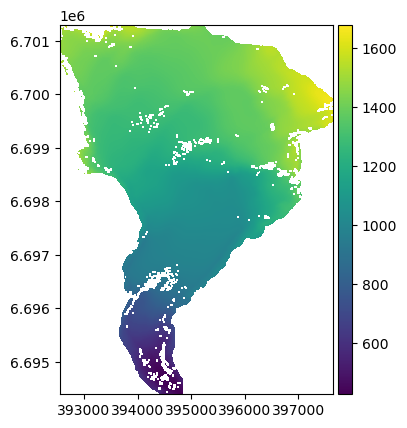

In [24]:

# load dems (lazily)
p = Path(ROOT, "data/external/usgs/dem/Wolverine_2020/Wolverine_2020.10.19_DEM.tif")
wolv_dem = riox.open_rasterio(p,chunks={"x":1000, "y":1000}, mask_and_scale=True).sel(band=1)
# trim DEM first
wolv_geom = wolv.geometry.to_crs(wolv_dem.rio.crs)
wolv_dem = wolv_dem.rio.clip(wolv_geom.envelope)

w0, h0 = wolv_dem.shape
print(wolv_dem.shape)  # check initial size
# now do expensive resampling
factor = 2
wolv_dem = resample(wolv_dem, factor, "up")
wolv_gdem = wolv_dem.rio.clip(wolv_geom.buffer(100))
wolv_icefree = wolv_dem.rio.clip(wolv_geom, invert=True)
wolv_gxdem = riox_to_xdem(wolv_gdem)
print(wolv_gxdem.data.shape)  # check final size

(23014, 17037)
(5754, 4260)


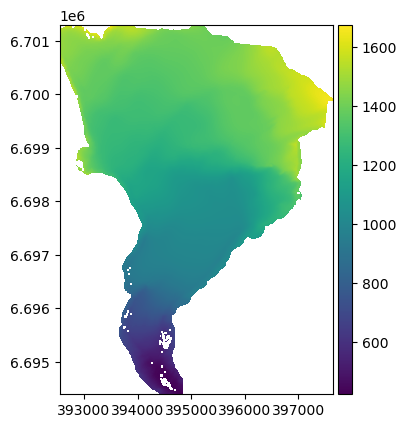

In [25]:
p = Path(ROOT, "data/external/usgs/dem/Wolverine_2020/Wolverine_2020.05.02_DEM.tif")
wolv_spr_dem = riox.open_rasterio(p,chunks={"x":1000, "y":1000}, mask_and_scale=True).sel(band=1)
# trim DEM first
wolv_geom = wolv.geometry.to_crs(wolv_spr_dem.rio.crs)
wolv_spr_dem = wolv_spr_dem.rio.clip(wolv_geom.envelope)

w0, h0 = wolv_dem.shape
print(wolv_spr_dem.shape)  # check initial size
# now do expensive resampling
factor = 4
wolv_spr_dem = resample(wolv_spr_dem, factor, "up")
wolv_spr_gdem = wolv_spr_dem.rio.clip(wolv_geom.buffer(100))
wolv_spr_icefree = wolv_spr_dem.rio.clip(wolv_geom, invert=True)
wolv_spr_gxdem = riox_to_xdem(wolv_spr_gdem)
print(wolv_spr_gxdem.data.shape)  # check final size


(3064, 1607)
(3064, 1607)


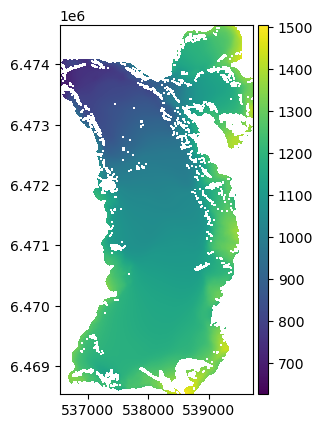

In [26]:

p = Path(ROOT, "data/external/usgs/dem/LemonCreek_2021/LemonCreek_2021.10.05_DEM.tif")
lemon_dem = riox.open_rasterio(p,chunks={"x":1000, "y":1000}, mask_and_scale=True).sel(band=1)

lemon_geom = lemon.geometry.to_crs(lemon_dem.rio.crs)
lemon_dem = lemon_dem.rio.clip(lemon_geom.envelope)

w0, h0 = lemon_dem.shape
print(lemon_dem.shape)
factor = 1
lemon_dem = resample(lemon_dem, factor, "up")
lemon_gdem = lemon_dem.rio.clip(lemon_geom.buffer(100))
lemon_icefree = lemon_dem.rio.clip(lemon_geom, invert=True)
lemon_gxdem = riox_to_xdem(lemon_gdem)

print(lemon_gxdem.shape)

(24901, 16387)
(6226, 4097)


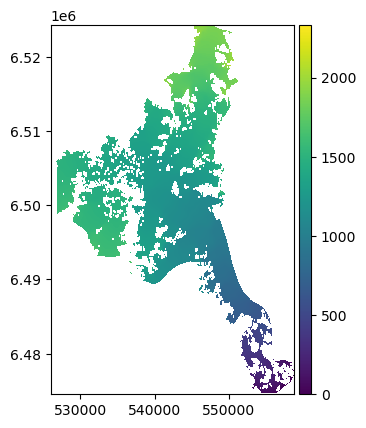

In [27]:

p = Path(ROOT, "data/external/usgs/dem/Taku_2018/Taku_2018.10.01_DEM.tif")
taku_dem = riox.open_rasterio(p,chunks={"x":1000, "y":1000}, mask_and_scale=True).sel(band=1)

taku_geom = taku.geometry.to_crs(taku_dem.rio.crs)
taku_dem = taku_dem.rio.clip(taku_geom.envelope)

w0, h0 = taku_dem.shape
print(taku_dem.shape)
factor=4
taku_dem = resample(taku_dem, factor, "up")
taku_gdem = taku_dem.rio.clip(taku_geom.buffer(300))
taku_icefree = taku_dem.rio.clip(taku_geom, invert=True)
taku_gxdem = riox_to_xdem(taku_gdem)
print(taku_gxdem.shape)

(2770, 4041)


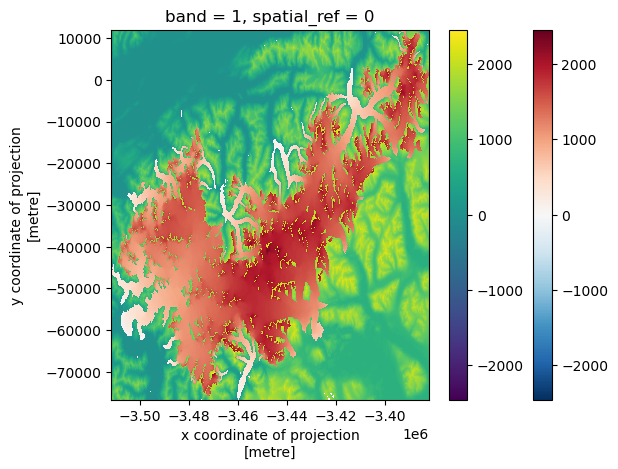

In [28]:
# read in with rioxarray to crop
p = Path(ROOT, "data/external/artcicDEM_32.tif")
jif_dem = riox.open_rasterio(p,chunks={"x":1000, "y":1000}, mask_and_scale=True).sel(band=1)
jif_geom = jif.geometry.to_crs(jif_dem.rio.crs)
jif_dem = jif_dem.rio.clip(jif_geom.envelope)

w0, h0 = jif_dem.shape
print(jif_dem.shape)
jif_icefree = jif_dem.rio.clip(jif_geom, invert=True)
jif_dem = jif_dem.rio.clip(jif_geom.buffer(300))

fig, ax = plt.subplots()
jif_dem.plot(ax=ax)
jif_icefree.plot(ax=ax, cmap='viridis')

(2770, 4041)


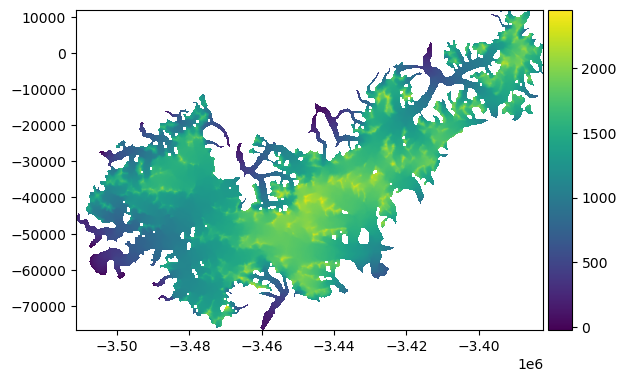

In [29]:

jif_xdem = riox_to_xdem(jif_dem)
print(jif_xdem.shape)

In [30]:
# def lowpass2d(image, cutoff_frequency = 10):
#     # Define the cutoff frequency in length units (e.g., pixels)


#     # Perform 2D FFT and shift the zero frequency component to the center
#     freq_domain_image = sci.fft.fftshift(sci.fft.fft2(image.filled(0)))

#     # Create a 2D low-pass filter mask
#     rows, cols = image.shape
#     crow, ccol = rows // 2 , cols // 2

#     # Create a circular mask with a radius of cutoff_frequency
#     mask = np.zeros((rows, cols), dtype=np.float32)
#     y, x = np.ogrid[:rows, :cols]
#     center = (crow, ccol)
#     distance_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
#     mask[distance_from_center <= cutoff_frequency] = 1

#     # Apply the mask to the frequency domain image
#     filtered_freq_domain_image = freq_domain_image * mask

#     # Perform the inverse 2D FFT to get the filtered image back in spatial domain
#     filtered_image = sci.fft.ifft2(sci.fft.ifftshift(filtered_freq_domain_image))
#     filtered_image = np.abs(filtered_image)
#     filtered_image = np.ma.masked_array(filtered_image, mask=mask)
    
#     return filtered_image

In [31]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate a colormap to use only a part of it.

    Parameters:
    - cmap: The original colormap.
    - minval: The lower limit of the colormap (between 0.0 and 1.0).
    - maxval: The upper limit of the colormap (between 0.0 and 1.0).
    - n: The number of colors in the new colormap.

    Returns:
    - A new truncated colormap.
    """
    cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

def quantile_boundary_norm(values, quantiles: tuple, nlevels=30):
    pct_min, pct_max = np.nanquantile(values, quantiles)
    bounds = np.linspace(pct_min, pct_max, nlevels)
    norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    return norm

def calc_terrain_stats(dem: xdem.DEM, fns: list[callable], nodata=np.nan, path_prefix=None, plot=False, use_richdem=False,  plot_geom=None, bg_dem=None, smooth=None, cmap_name='RdYlBu'):
    for fn in tqdm(fns):
        try:
            stat = fn(dem, use_richdem=use_richdem)
        except:
            stat = fn(dem)
        stat.set_nodata(nodata)
        
        if smooth is not None:
            stat.data = snd.gaussian_filter(stat.data, sigma=smooth)
            #stat.data = lowpass2d(stat.data)
        
        name = fn.__name__
        filename = f"{path_prefix}_{name}_{cmap_name}"
        stat.save(Path(f'output/{filename}.tif'))
        
        
        if plot:
            x,y = stat.coords()
            ma = stat.data
            aspect = len(y)/len(x)
            width = 10
            fig, ax = plt.subplots(dpi=200, figsize=(width, width*aspect), layout='constrained')
            
            if bg_dem is not None:
                norm = quantile_boundary_norm(bg_dem.values, (0.1, 0.9), nlevels=30)
                bg_dem.plot(cmap='Grays', alpha=0.5, ax=ax, norm=norm, add_colorbar=False)
            
            norm = quantile_boundary_norm(ma.filled(np.nan), (0.1, 0.9), nlevels=60)
            
            #cmap = truncate_colormap('RdYlBu', 0.1, 0.9)
            #cmap = truncate_colormap('twilight', 0, 1)
            #cmap = truncate_colormap('plasma', 0.1, 1)
            cmap = truncate_colormap(cmap_name, 0.1, 0.9)
            
            mesh = ax.pcolormesh(x, y, ma, norm=norm, cmap=cmap, antialiased=True, lw=0)
            plt.colorbar(mesh, fraction=0.046, pad=0.04, extend='both')
            
            plot_geom.plot(ax=ax, lw=0.5, edgecolor='black', facecolor='none')
            ax.set_aspect('equal')
            ax.set_title(name)
            plt.savefig(Path(f"output/{filename}.png"))
            plt.close(fig)    
            

In [32]:

# embarassingly parallel            
fns = [
    xdem.terrain.curvature,
    xdem.terrain.profile_curvature,
    xdem.terrain.planform_curvature,
    xdem.terrain.maximum_curvature,
    xdem.terrain.topographic_position_index,
    xdem.terrain.aspect,
    xdem.terrain.slope,
    xdem.terrain.roughness,
    xdem.terrain.terrain_ruggedness_index,
    xdem.terrain.rugosity,
    xdem.terrain.fractal_roughness,
]

cmap='twilight_shifted'

In [33]:

calc_terrain_stats(jif_xdem, fns, path_prefix="jif", plot=True, plot_geom=jif_geom, bg_dem=jif_icefree, smooth=1)

100%|██████████| 11/11 [02:48<00:00, 15.28s/it]


In [34]:
# The USGS DEMs are much higher resolution and will take longer to run
calc_terrain_stats(wolv_gxdem, fns, path_prefix="wolv", plot=True, plot_geom=wolv_geom, bg_dem=wolv_icefree, smooth=2)
calc_terrain_stats(wolv_spr_gxdem, fns, path_prefix="wolv_spr", plot=True, plot_geom=wolv_geom, bg_dem=wolv_icefree, smooth=2)

100%|██████████| 11/11 [03:57<00:00, 21.60s/it]


In [35]:
calc_terrain_stats(lemon_gxdem, fns, path_prefix="lemon", plot=True, plot_geom=lemon_geom, bg_dem=lemon_icefree, smooth=2)

100%|██████████| 11/11 [01:47<00:00,  9.73s/it]


In [36]:
calc_terrain_stats(taku_gxdem, fns, path_prefix="taku", plot=True, plot_geom=taku_geom, bg_dem=taku_icefree, smooth=4)

100%|██████████| 11/11 [08:16<00:00, 45.18s/it]
